In [1]:
%pylab inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from scipy import stats
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
from glob import glob as gb
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)
!pwd

Populating the interactive namespace from numpy and matplotlib
netcdf_index loaded.
Available exptdata keys:  ['1deg', '025deg', '01deg']
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `BASH_FUNC_module'
/home/561/erd561/ACCESS-OM2-1-025-010deg-report/figures/Australia


In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

output_dir = '/home/561/erd561/figures/Australia/'
fig_name = nb_name[:-6]
fig_dir = output_dir + fig_name

output_ls = os.listdir(output_dir)
if fig_name not in output_ls:
    os.mkdir(fig_dir)
    
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync

years = list(range(1993, 2018))

1993-2017
tstart =  1993-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [4]:
%%time

from dask.distributed import Client
c = Client()
print(c)

<Client: scheduler='tcp://127.0.0.1:37330' processes=8 cores=8>
CPU times: user 857 ms, sys: 219 ms, total: 1.08 s
Wall time: 4.24 s


**The function below** calculates the quasi-barotropic streamfunction for each simulation. In each case, we read in only the last IAF cycle, then we average over the standard time period.

In [21]:
%%time
lat_line = -47
lonW = 90-360
lonE = 180-360
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
time_units = exptdata.exptdict[ekey]['time_units']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']
print(expt)
print(time_units)
print(n_files)
print(offset)
temp = cc.get_nc_variable(expt,'ocean.nc','temp',time_units=time_units,n=n_files,offset=offset).\
                            sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).\
                            sel(yt_ocean=lat_line, method='nearest').\
                            sel(xt_ocean=slice(lonW,lonE)).\
                            groupby('time.year').mean(dim='time', skipna=True)
temp.load()
print(temp)

025deg_jra55v13_iaf_gmredi6
days since 1718-01-01
-34
-87658
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
<xarray.DataArray 'temp' (year: 25, st_ocean: 50, xt_ocean: 360)>
array([[[282.82733, 282.77686, ..., 283.53424, 283.55737],
        [282.83167, 282.78104, ..., 283.53067, 283.55344],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[282.7393 , 282.74078, ..., 283.7297 , 283.75317],
        [282.74213, 282.74368, ..., 283.72476, 283.7483 ],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[282.90256, 282.90784, ..., 283.89706, 283.92844],
        [282.90613, 282.9114 , ..., 283.8903 , 283.92175],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[282.7217 , 282

In [22]:
%%time
salt = cc.get_nc_variable(expt,'ocean.nc','salt',time_units=time_units,n=n_files,offset=offset).\
                            sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).\
                            sel(yt_ocean=lat_line, method='nearest').\
                            sel(xt_ocean=slice(lonW,lonE)).\
                            groupby('time.year').mean(dim='time', skipna=True)

salt.load()
print(salt)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
<xarray.DataArray 'salt' (year: 25, st_ocean: 50, xt_ocean: 360)>
array([[[34.567677, 34.56228 , ..., 34.418415, 34.422688],
        [34.56785 , 34.56246 , ..., 34.418617, 34.42291 ],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[34.67701 , 34.673557, ..., 34.404774, 34.407703],
        [34.67744 , 34.674   , ..., 34.404995, 34.407936],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[34.68518 , 34.675026, ..., 34.40044 , 34.405304],
        [34.685276, 34.675114, ..., 34.40072 , 34.405525],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[34.53526 , 34.510727, ..., 34.40441 , 34.4101  ],
        [34.53554 , 34.51

In [23]:
%%time
u = cc.get_nc_variable(expt,'ocean.nc','u',time_units=time_units,n=n_files,offset=offset).\
                            sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).\
                            sel(yu_ocean=lat_line, method='nearest').\
                            sel(xu_ocean=slice(lonW,lonE)).\
                            groupby('time.year').mean(dim='time', skipna=True)

u.load()
print(u)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
<xarray.DataArray 'u' (year: 25, st_ocean: 50, xu_ocean: 361)>
array([[[0.153029, 0.140514, ..., 0.21578 , 0.231135],
        [0.120237, 0.107781, ..., 0.204867, 0.220293],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[0.085686, 0.086359, ..., 0.199439, 0.214811],
        [0.055251, 0.05604 , ..., 0.184776, 0.200192],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       ...,

       [[0.085404, 0.08785 , ..., 0.282806, 0.299583],
        [0.052821, 0.055445, ..., 0.269619, 0.286394],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[0.090514, 0.089418, ..., 0.268424, 0.287162],
        [0.060542, 0.059556, ..., 0.258325, 0.277116],
        ...,
        [   

In [24]:
%%time
v = cc.get_nc_variable(expt,'ocean.nc','v',time_units=time_units,n=n_files,offset=offset).\
                            sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).\
                            sel(yu_ocean=lat_line, method='nearest').\
                            sel(xu_ocean=slice(lonW,lonE)).\
                            groupby('time.year').mean(dim='time', skipna=True)

v.load()
print(v)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
<xarray.DataArray 'v' (year: 25, st_ocean: 50, xu_ocean: 361)>
array([[[ 6.041666e-02,  7.590090e-02, ...,  5.649921e-03, -1.879491e-02],
        [ 5.719904e-02,  7.287724e-02, ...,  4.594454e-03, -1.987683e-02],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan]],

       [[ 5.012178e-02,  6.021478e-02, ...,  1.410042e-02, -7.458853e-03],
        [ 4.769480e-02,  5.799992e-02, ...,  1.304538e-02, -8.571332e-03],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan]],

       ...,

       [[ 7.482096e-02,  8.197095e-02, ..., -2.404713e-05, -1.707805e-02],
        [ 7.123510e-02,  7.848608e-02, ...,  3.915484e-04, -1.669345e-02],
        ...,
        [          nan,           nan, ...,    

In [25]:
%%time
wt = cc.get_nc_variable(expt,'ocean.nc','wt',time_units=time_units,n=n_files,offset=offset).\
                            sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).\
                            sel(yt_ocean=lat_line, method='nearest').\
                            sel(xt_ocean=slice(lonW,lonE)).\
                            groupby('time.year').mean(dim='time', skipna=True)

wt.load()
print(wt)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
<xarray.DataArray 'wt' (year: 25, sw_ocean: 50, xt_ocean: 360)>
array([[[ 1.223607e-07,  9.574537e-08, ..., -3.854494e-08, -5.218369e-08],
        [ 2.657461e-07,  2.053013e-07, ..., -7.431036e-08, -1.118876e-07],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan]],

       [[-2.560771e-07, -2.530502e-07, ..., -5.282962e-08, -6.942948e-08],
        [-5.330700e-07, -5.346856e-07, ..., -9.920246e-08, -1.450188e-07],
        ...,
        [          nan,           nan, ...,           nan,           nan],
        [          nan,           nan, ...,           nan,           nan]],

       ...,

       [[-2.143410e-07, -2.053324e-07, ..., -1.058612e-07, -5.036177e-08],
        [-4.552215e-07, -4.418775e-07, ..., -2.175088e-07, -9.518562e-08],
        ...,
        [          nan,           nan, ...,   

In [26]:
%%time
eta_t_month = cc.get_nc_variable(expt,'ocean_month.nc','eta_t',time_units=time_units,n=n_files,offset=offset).\
                            sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).\
                            sel(yt_ocean=lat_line, method='nearest').\
                            sel(xt_ocean=slice(lonW,lonE))

eta_t_month.load()
print(eta_t_month)

eta_t = eta_t_month.groupby('time.year').mean('time', skipna=True)
print(eta_t)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
<xarray.DataArray 'eta_t' (time: 300, xt_ocean: 360)>
array([[-0.106727, -0.115515, -0.129512, ..., -0.074175, -0.073588, -0.06987 ],
       [-0.082699, -0.096332, -0.114984, ..., -0.059843, -0.057582, -0.05191 ],
       [-0.057045, -0.072713, -0.092972, ..., -0.059125, -0.056812, -0.05194 ],
       ...,
       [-0.053116, -0.073809, -0.102523, ..., -0.007331, -0.003759, -0.000288],
       [-0.057736, -0.068745, -0.084638, ..., -0.011979, -0.007604, -0.001536],
       [-0.010702, -0.021554, -0.038126, ...,  0.004914,  0.009415,  0.019067]],
      dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -269.9 -269.6 -269.4 ... -180.6 -180.4 -180.1
    yt_ocean  float64 -47.0
  * time      (time) datetime64[ns] 1993-01-14T12:00:00 ... 2017-12-14T12:00:00
Attributes:
    long_name:      surface height on T cells [Boussinesq (volume conserving)...
    units:          meter
    valid_range:    [-1000.  

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [27]:
%%time
mld_month = cc.get_nc_variable(expt,'ocean_month.nc','mld',time_units=time_units,n=n_files,offset=offset).\
                            sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).\
                            sel(yt_ocean=lat_line, method='nearest').\
                            sel(xt_ocean=slice(lonW,lonE))

mld_month.load()
print(mld_month)

mld = mld_month.groupby('time.year').mean('time', skipna=True)
print(mld)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
<xarray.DataArray 'mld' (time: 300, xt_ocean: 360)>
array([[ 68.54248 ,  77.574005,  81.011086, ...,  26.64157 ,  26.58969 ,
         26.478163],
       [100.83631 , 108.23673 , 108.74031 , ...,  23.192327,  22.951084,
         22.767845],
       [104.34206 , 108.51332 , 114.60675 , ...,  35.29587 ,  35.154045,
         35.05251 ],
       ...,
       [456.57205 , 441.7239  , 427.829   , ...,  42.111652,  42.442814,
         42.82116 ],
       [300.54102 , 302.23947 , 287.20328 , ...,  23.217085,  23.665936,
         23.743902],
       [ 67.09791 ,  73.449234,  82.8561  , ...,  12.406199,  12.499736,
         12.525533]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -269.9 -269.6 -269.4 ... -180.6 -180.4 -180.1
    yt_ocean  float64 -47.0
  * time      (time) datetime64[ns] 1993-01-14T12:00:00 ... 2017-12-14T12:00:00
Attributes:
    long_name:      mixed layer depth determined by density 

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [28]:
%%time

var = 'rain'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

rain = xr.open_mfdataset(all_files).prrn.\
                            sel(latitude=lat_line, method='nearest').\
                            groupby('time.year').mean(dim='time', skipna=True)

rain.load()
print(rain)

<xarray.DataArray 'prrn' (year: 25, longitude: 161)>
array([[4.129898e-05, 4.112097e-05, 4.086220e-05, ..., 2.379753e-05,
        2.361864e-05, 2.353789e-05],
       [3.899704e-05, 3.914491e-05, 3.938749e-05, ..., 2.611933e-05,
        2.626524e-05, 2.632943e-05],
       [3.479998e-05, 3.440979e-05, 3.448466e-05, ..., 2.353422e-05,
        2.493368e-05, 2.612681e-05],
       ...,
       [3.613622e-05, 3.576323e-05, 3.558905e-05, ..., 2.173423e-05,
        2.143869e-05, 2.050149e-05],
       [3.429421e-05, 3.430287e-05, 3.425824e-05, ..., 2.483492e-05,
        2.538285e-05, 2.621832e-05],
       [3.664931e-05, 3.670577e-05, 3.683562e-05, ..., 2.535506e-05,
        2.536248e-05, 2.590215e-05]], dtype=float32)
Coordinates:
    latitude   float64 -46.9
  * longitude  (longitude) float64 90.0 90.56 91.12 91.69 ... 178.9 179.4 180.0
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2014 2015 2016 2017
CPU times: user 532 ms, sys: 45 ms, total: 577 ms
Wall time: 568 ms


In [29]:
%%time

var = 't_10'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

t_10 = xr.open_mfdataset(all_files).tas_10m.\
                            sel(latitude=lat_line, method='nearest').\
                            groupby('time.year').mean(dim='time', skipna=True)

t_10.load()
print(t_10)

<xarray.DataArray 'tas_10m' (year: 25, longitude: 161)>
array([[280.32785, 280.31198, 280.29416, ..., 282.9293 , 282.9163 , 282.91245],
       [280.5259 , 280.527  , 280.5252 , ..., 283.17743, 283.1578 , 283.1443 ],
       [280.61707, 280.6125 , 280.6064 , ..., 283.0188 , 283.02078, 283.0295 ],
       ...,
       [280.70862, 280.6846 , 280.66113, ..., 282.6182 , 282.6159 , 282.61707],
       [280.79102, 280.77036, 280.74612, ..., 283.34045, 283.318  , 283.30237],
       [280.6544 , 280.63483, 280.60953, ..., 283.5196 , 283.53857, 283.55627]],
      dtype=float32)
Coordinates:
    latitude   float64 -46.9
  * longitude  (longitude) float64 90.0 90.56 91.12 91.69 ... 178.9 179.4 180.0
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2014 2015 2016 2017
CPU times: user 655 ms, sys: 76 ms, total: 731 ms
Wall time: 709 ms


In [30]:
%%time

var = 'u_10'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

u_10 = xr.open_mfdataset(all_files).uas_10m.\
                            sel(latitude=lat_line, method='nearest').\
                            groupby('time.year').mean(dim='time', skipna=True)

u_10.load()
print(u_10)

<xarray.DataArray 'uas_10m' (year: 25, longitude: 161)>
array([[9.645839, 9.588848, 9.525734, ..., 3.375994, 3.344712, 3.320746],
       [8.845517, 8.795547, 8.741001, ..., 4.307901, 4.300899, 4.304658],
       [8.193247, 8.124542, 8.046256, ..., 3.878624, 3.883888, 3.893475],
       ...,
       [8.716171, 8.66328 , 8.603413, ..., 4.289868, 4.311243, 4.345916],
       [9.490237, 9.431581, 9.34796 , ..., 3.872182, 3.936556, 4.004777],
       [8.849998, 8.795258, 8.725463, ..., 2.885799, 2.920327, 2.966213]],
      dtype=float32)
Coordinates:
    latitude   float64 -46.9
  * longitude  (longitude) float64 90.0 90.56 91.12 91.69 ... 178.9 179.4 180.0
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2014 2015 2016 2017
CPU times: user 849 ms, sys: 66 ms, total: 915 ms
Wall time: 885 ms


In [31]:
%%time

var = 'slp'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

slp = xr.open_mfdataset(all_files).psl.\
                            sel(latitude=lat_line, method='nearest').\
                            groupby('time.year').mean(dim='time', skipna=True)

slp.load()
print(slp)

<xarray.DataArray 'psl' (year: 25, longitude: 161)>
array([[100469.625, 100460.06 , 100451.37 , ..., 101145.93 , 101141.95 ,
        101137.31 ],
       [100332.89 , 100327.89 , 100323.92 , ..., 100868.516, 100865.516,
        100862.05 ],
       [100698.56 , 100696.8  , 100695.695, ..., 101053.28 , 101053.99 ,
        101054.59 ],
       ...,
       [100843.13 , 100840.484, 100838.34 , ..., 101134.59 , 101130.52 ,
        101126.17 ],
       [100670.945, 100660.42 , 100650.5  , ..., 101036.305, 101036.695,
        101036.53 ],
       [100686.47 , 100676.35 , 100666.77 , ..., 101208.07 , 101209.12 ,
        101209.8  ]], dtype=float32)
Coordinates:
    latitude   float64 -46.9
  * longitude  (longitude) float64 90.0 90.56 91.12 91.69 ... 178.9 179.4 180.0
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2014 2015 2016 2017
CPU times: user 546 ms, sys: 66 ms, total: 612 ms
Wall time: 609 ms


In [32]:
%%time

var = 'v_10'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

v_10 = xr.open_mfdataset(all_files).vas_10m.\
                            sel(latitude=lat_line, method='nearest').\
                            groupby('time.year').mean(dim='time', skipna=True)

v_10.load()
print(v_10)

<xarray.DataArray 'vas_10m' (year: 25, longitude: 161)>
array([[ 0.092056, -0.004957, -0.116251, ...,  0.178056,  0.196661,  0.156698],
       [-0.183939, -0.293357, -0.41627 , ...,  0.035193,  0.038388, -0.001606],
       [-0.527131, -0.587537, -0.673572, ..., -0.283182, -0.320837, -0.409697],
       ...,
       [-0.64481 , -0.703715, -0.785693, ..., -0.09575 , -0.100405, -0.137062],
       [ 0.243442,  0.180187,  0.095663, ..., -0.420265, -0.386965, -0.408777],
       [ 0.277554,  0.219833,  0.154644, ..., -0.191533, -0.173563, -0.18706 ]],
      dtype=float32)
Coordinates:
    latitude   float64 -46.9
  * longitude  (longitude) float64 90.0 90.56 91.12 91.69 ... 178.9 179.4 180.0
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2014 2015 2016 2017
CPU times: user 497 ms, sys: 48 ms, total: 545 ms
Wall time: 548 ms


In [33]:
temp_mean = temp.mean(dim='year')
print(temp_mean)
temp_anom = temp - temp_mean

salt_mean = salt.mean(dim='year')
print(salt_mean)
salt_anom = salt - salt_mean

u_mean = u.mean(dim='year')
print(u_mean)
u_anom = u - u_mean

v_mean = v.mean(dim='year')
print(v_mean)
v_anom = v - v_mean

wt_mean = wt.mean(dim='year')
print(wt_mean)
wt_anom = wt - wt_mean

eta_t_mean = eta_t.mean(dim='year')
print(eta_t_mean)
eta_t_anom = eta_t - eta_t_mean

mld_mean = mld.mean(dim='year')
print(mld_mean)
mld_anom = mld - mld_mean

rain_mean = rain.mean(dim='year')
print(rain_mean)
rain_anom = rain - rain_mean

t_10_mean = t_10.mean(dim='year')
print(t_10_mean)
t_10_anom = t_10 - t_10_mean

u_10_mean = u_10.mean(dim='year')
print(u_10_mean)
u_10_anom = u_10 - u_10_mean

v_10_mean = v_10.mean(dim='year')
print(v_10_mean)
v_10_anom = v_10 - v_10_mean

slp_mean = slp.mean(dim='year')
print(slp_mean)
slp_anom = slp - slp_mean

<xarray.DataArray 'temp' (st_ocean: 50, xt_ocean: 360)>
array([[282.57132, 282.53412, 282.5008 , ..., 283.80505, 283.81903, 283.8472 ],
       [282.5741 , 282.5368 , 282.50336, ..., 283.79825, 283.81232, 283.84064],
       [282.5737 , 282.53644, 282.5029 , ..., 283.78763, 283.80173, 283.82996],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
  * st_ocean  (st_ocean) float64 1.152 3.649 6.565 ... 5.034e+03 5.254e+03
  * xt_ocean  (xt_ocean) float64 -269.9 -269.6 -269.4 ... -180.6 -180.4 -180.1
    yt_ocean  float64 -47.0
<xarray.DataArray 'salt' (st_ocean: 50, xt_ocean: 360)>
array([[34.59204 , 34.587593, 34.581066, ..., 34.420998, 34.423992, 34.428696],
       [34.592243, 34.58779 , 34.58128 , ..., 34.42124 , 34.424232, 34.428917],
       [34.59239 , 

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [34]:
x = temp.xt_ocean
y = temp.st_ocean
temp_slopes = xr.DataArray(np.zeros([y.shape[0], x.shape[0]]), dims=(
    'y', 'x'), coords=[y, x], name='temp')
for iid, i in enumerate(y):
    for jid, j in enumerate(x):
        temp_slopes[iid, jid], _, _, _, _ = \
        stats.linregress(years, temp[:, iid, jid])
    print('st_ocean ' + str(np.array(i)))
print(temp_slopes)

salt_slopes = xr.DataArray(np.zeros([y.shape[0], x.shape[0]]), dims=(
    'y', 'x'), coords=[y, x], name='salt')
for iid, i in enumerate(y):
    for jid, j in enumerate(x):
        salt_slopes[iid, jid], _, _, _, _ = \
        stats.linregress(years, salt[:, iid, jid])
    print('st_ocean ' + str(np.array(i)))
print(salt_slopes)

wt_slopes = xr.DataArray(np.zeros([y.shape[0], x.shape[0]]), dims=(
    'y', 'x'), coords=[y, x], name='wt')
for iid, i in enumerate(y):
    for jid, j in enumerate(x):
        wt_slopes[iid, jid], _, _, _, _ = \
        stats.linregress(years, wt[:, iid, jid])
    print('st_ocean ' + str(np.array(i)))
print(wt_slopes) 

eta_t_slopes = xr.DataArray(np.zeros([x.shape[0]]), dims=(
    'x'), coords=[x], name='eta_t')
for jid, i in enumerate(x):
    eta_t_slopes[jid], _, _, _, _ = \
    stats.linregress(years, eta_t[:, jid])
print(eta_t_slopes) 

mld_slopes = xr.DataArray(np.zeros([x.shape[0]]), dims=(
    'x'), coords=[x], name='mld')
for jid, i in enumerate(x):
    mld_slopes[jid], _, _, _, _ = \
    stats.linregress(years, mld[:, jid])
print(mld_slopes) 

x = u.xu_ocean
u_slopes = xr.DataArray(np.zeros([y.shape[0], x.shape[0]]), dims=(
    'y', 'x'), coords=[y, x], name='u')
for iid, i in enumerate(y):
    for jid, j in enumerate(x):
        u_slopes[iid, jid], _, _, _, _ = \
        stats.linregress(years, u[:, iid, jid])
    print('st_ocean ' + str(np.array(i)))
print(u_slopes) 

v_slopes = xr.DataArray(np.zeros([y.shape[0], x.shape[0]]), dims=(
    'y', 'x'), coords=[y, x], name='v')
for iid, i in enumerate(y):
    for jid, j in enumerate(x):
        v_slopes[iid, jid], _, _, _, _ = \
        stats.linregress(years, v[:, iid, jid])
    print('st_ocean ' + str(np.array(i)))
print(v_slopes) 

x = t_10.longitude
t_10_slopes = xr.DataArray(np.zeros([x.shape[0]]), dims=(
    'x'), coords=[x], name='t_10')
for jid, i in enumerate(x):
    t_10_slopes[jid], _, _, _, _ = \
    stats.linregress(years, t_10[:, jid])
print(t_10_slopes)

rain_slopes = xr.DataArray(np.zeros([x.shape[0]]), dims=(
    'x'), coords=[x], name='rain')
for jid, i in enumerate(x):
    rain_slopes[jid], _, _, _, _ = \
    stats.linregress(years, rain[:, jid])
print(rain_slopes)

slp_slopes = xr.DataArray(np.zeros([x.shape[0]]), dims=(
    'x'), coords=[x], name='slp')
for jid, i in enumerate(x):
    slp_slopes[jid], _, _, _, _ = \
    stats.linregress(years, slp[:, jid])
print(slp_slopes)

u_10_slopes = xr.DataArray(np.zeros([x.shape[0]]), dims=(
    'x'), coords=[x], name='u_10')
for jid, i in enumerate(x):
    u_10_slopes[jid], _, _, _, _ = \
    stats.linregress(years, u_10[:, jid])
print(u_10_slopes)

v_10_slopes = xr.DataArray(np.zeros([x.shape[0]]), dims=(
    'x'), coords=[x], name='v_10')
for jid, i in enumerate(x):
    v_10_slopes[jid], _, _, _, _ = \
    stats.linregress(years, v_10[:, jid])
print(v_10_slopes)

st_ocean 1.15174989182586
st_ocean 3.6486741197120196
st_ocean 6.564918471676153
st_ocean 9.970869194872916
st_ocean 13.948708373749158
st_ocean 18.594379460593196
st_ocean 24.019873617545198
st_ocean 30.355885242559452
st_ocean 37.754889932903495
st_ocean 46.39470194845016
st_ocean 56.48256969937929
st_ocean 68.25986482598941
st_ocean 82.00740970018322
st_ocean 98.05146439730592
st_ocean 116.77034928747688
st_ocean 138.60160118643546
st_ocean 164.04943216631892
st_ocean 193.69205664349184
st_ocean 228.1881444592732
st_ocean 268.2812141854562
st_ocean 314.800181990729
st_ocean 368.65354740782504
st_ocean 430.8139438640983
st_ocean 502.28929308570173
st_ocean 584.0771003035616
st_ocean 677.1002526914099
st_ocean 782.1267221440287
st_ocean 899.6817765561261
st_ocean 1029.9681126743835
st_ocean 1172.813371535859
st_ocean 1327.6620295174746
st_ocean 1493.618454761941
st_ocean 1669.533396965427
st_ocean 1854.1141182462907
st_ocean 2046.0343763841533
st_ocean 2244.0251574257236
st_ocean 2446

st_ocean 1.15174989182586
st_ocean 3.6486741197120196
st_ocean 6.564918471676153
st_ocean 9.970869194872916
st_ocean 13.948708373749158
st_ocean 18.594379460593196
st_ocean 24.019873617545198
st_ocean 30.355885242559452
st_ocean 37.754889932903495
st_ocean 46.39470194845016
st_ocean 56.48256969937929
st_ocean 68.25986482598941
st_ocean 82.00740970018322
st_ocean 98.05146439730592
st_ocean 116.77034928747688
st_ocean 138.60160118643546
st_ocean 164.04943216631892
st_ocean 193.69205664349184
st_ocean 228.1881444592732
st_ocean 268.2812141854562
st_ocean 314.800181990729
st_ocean 368.65354740782504
st_ocean 430.8139438640983
st_ocean 502.28929308570173
st_ocean 584.0771003035616
st_ocean 677.1002526914099
st_ocean 782.1267221440287
st_ocean 899.6817765561261
st_ocean 1029.9681126743835
st_ocean 1172.813371535859
st_ocean 1327.6620295174746
st_ocean 1493.618454761941
st_ocean 1669.533396965427
st_ocean 1854.1141182462907
st_ocean 2046.0343763841533
st_ocean 2244.0251574257236
st_ocean 2446

<xarray.DataArray 'u_10' (x: 161)>
array([ 3.510294e-03,  3.757378e-03,  3.729409e-03,  3.861741e-03,
        3.882873e-03,  3.942425e-03,  4.172731e-03,  4.122839e-03,
        3.503177e-03,  3.119240e-03,  2.731981e-03,  2.410363e-03,
        1.480802e-03,  2.934672e-04, -3.076660e-04, -9.277931e-05,
        5.856063e-04,  1.241585e-03,  8.765756e-04, -4.975077e-04,
       -2.445923e-03, -4.313329e-03, -5.572986e-03, -6.024215e-03,
       -5.538935e-03, -5.116261e-03, -5.246661e-03, -5.498747e-03,
       -5.609427e-03, -5.484857e-03, -4.940361e-03, -3.761432e-03,
       -2.667920e-03, -1.994743e-03, -1.761695e-03, -1.792912e-03,
       -1.925477e-03, -1.933318e-03, -1.643781e-03, -1.039934e-03,
       -1.430251e-04,  7.117631e-04,  1.187838e-03,  1.436648e-03,
        1.399523e-03,  1.330729e-03,  1.603237e-03,  2.357894e-03,
        3.557218e-03,  5.044726e-03,  6.101746e-03,  6.725069e-03,
        6.997337e-03,  6.767490e-03,  6.151015e-03,  5.754415e-03,
        5.529405e-03,  5.80

-47
1993 OK


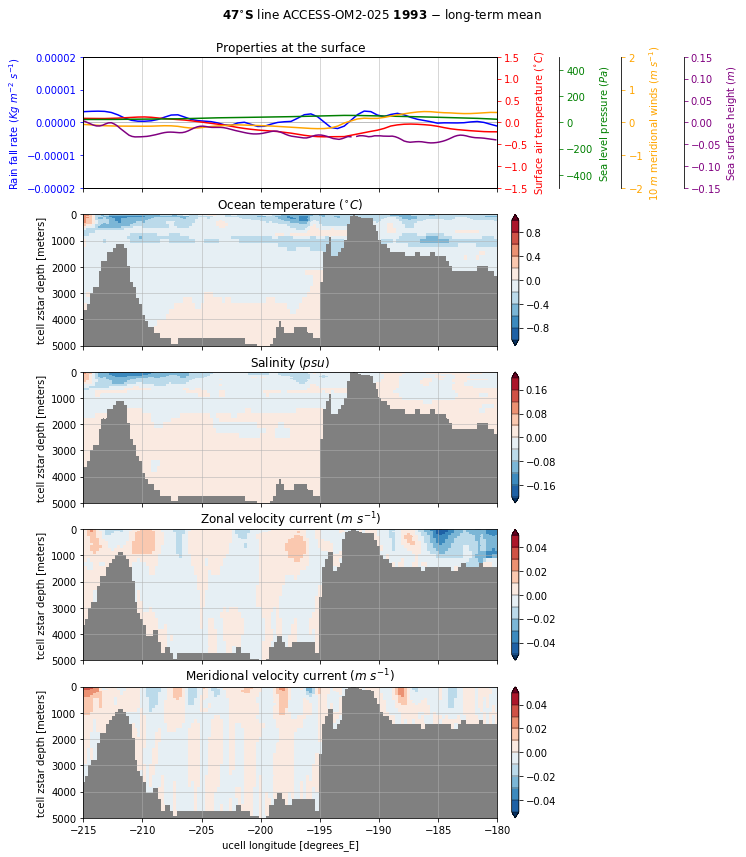

In [35]:
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(fig_dir, 
                             fig_name[0:4]+ekey+'_'+str(abs(lat_line))+'S_'+fname+'.png'),dpi=150, 
                bbox_inches="tight")  
    # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return    

print(lat_line)

# General plotting stuff
plot_labels=['(a) ','(b) ','(c) ','(d)']
land_50m= cft.NaturalEarthFeature('physical', 'land', '110m',
                                    edgecolor='black',
                                    facecolor='',
                                    linewidth=1)
fig = plt.figure() 
fig.set_size_inches(10,14)
matplotlib.rcParams.update({'font.size': 10}) 
col = 1
row = 5

lonW_lim = 145-360

for y_num in years[0:1]:
    y = str(y_num)

    fig.suptitle(r'$\bf{'+str(abs(lat_line))+'^{\circ}S}$ line ACCESS-OM2-025 $\\bf{'
                 + y + '}$ $-$ long-term mean', 
                 x=0.54, y=0.93)

    ax = plt.subplot2grid((row, col), (0, 0), rowspan=1, colspan=1)    
    # Twin the x-axis twice to make independent y-axes.
    axes = [ax, ax.twinx(), ax.twinx(), ax.twinx(), ax.twinx()]

    # Make some space on the right side for the extra y-axis.
    fig.subplots_adjust(right=0.7)

    # And finally we get to plot things...
    ax_num = 0
    color = 'Blue'
    ax_now = axes[ax_num]
    ylim = 0.00002
#     ylim = 100
    ax_now.plot([lonW_lim, lonE+360],[0,0],linewidth=0.5,color='Gray')
    ax_now.plot(rain_anom.longitude, rain_anom.sel(year=y_num), color=color)
    ax_now.set_ylabel('Rain fall rate ($Kg\ m^{-2}\ s^{-1}$)', color=color)
#     ax_now.set_ylabel('Mixed layer depth ($m$)', color=color)
    ax_now.tick_params(axis='y', colors=color)
    plt.gca().set_xlim([lonW_lim+360, lonE+360])
    ax_now.set_ylim([-ylim, ylim])
    
    ax_num = 1
    color = 'Red'
    ax_now = axes[ax_num]
    ylim = 1.5
    ax_now.plot(t_10_anom.longitude, t_10_anom.sel(year=y_num), color=color)
    ax_now.set_ylabel('Surface air temperature ($^{\circ}C$)', color=color)
    ax_now.tick_params(axis='y', colors=color)
    plt.gca().set_xlim([lonW_lim+360, lonE+360])
    ax_now.set_ylim([-ylim, ylim])
    
    ax_num = 2
    color = 'Green'
    axes[ax_num].spines['right'].set_position(('axes', 1.15))
    ax_now = axes[ax_num]
    ylim = 500
    ax_now.plot(t_10_anom.longitude, slp_anom.sel(year=y_num), color=color)
    ax_now.set_ylabel('Sea level pressure ($Pa$)', color=color)
    ax_now.tick_params(axis='y', colors=color)
    plt.gca().set_xlim([lonW_lim+360, lonE+360])
    ax_now.set_ylim([-ylim, ylim])
    
    ax_num = 3
    color = 'Orange'
    axes[ax_num].spines['right'].set_position(('axes', 1.3))
    ax_now = axes[ax_num]
    ylim = 2
    ax_now.plot(t_10_anom.longitude, v_10_anom.sel(year=y_num), color=color)
    ax_now.set_ylabel('10 $m$ meridional winds ($m\ s^{-1}$)', color=color)
    ax_now.tick_params(axis='y', colors=color)
    plt.gca().set_xlim([lonW_lim+360, lonE+360])
    ax_now.set_ylim([-ylim, ylim])
    
    ax_num = 4
    color = 'Purple'
    axes[ax_num].spines['right'].set_position(('axes', 1.45))
    axes[ax_num].set_frame_on(True)
    axes[ax_num].patch.set_visible(False)
    ax_now = axes[ax_num]
    ylim = 0.15
    ax_now.plot(eta_t_anom.xt_ocean+360, eta_t_anom.sel(year=y_num), color=color)
    ax_now.set_ylabel('Sea surface height ($m$)', color=color)
    ax_now.tick_params(axis='y', colors=color)
    plt.gca().set_xlim([lonW_lim, lonE])
    ax_now.set_ylim([-ylim, ylim])
    
    axes[0].xaxis.grid(linewidth=0.5, linestyle='-')
    axes[0].set_xlim([lonW_lim+360, lonE+360])
    ax_now.set_xticklabels('')
    ax_now.set_xlabel('')
    ax_now.set_title('Properties at the surface')


    ax = plt.subplot2grid((row, col), (1, 0), rowspan=1, colspan=1)
    cmap = plt.get_cmap('RdBu_r')
    levels = arange(-1,1,0.2)
    p = temp_anom.sel(
        year=y_num).plot(add_colorbar=False, cmap=cmap, levels=levels, extend='both')
    plt.title('Ocean temperature ($^{\circ}C$)')
    ax.grid(linewidth=0.5, linestyle='-')
    ax.set_xticks(arange(lonW,lonE,5))
    ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.set_xlim([lonW_lim, lonE])
    ax.set_ylim([0, 5000])
    ax.set_facecolor('gray')
    ax.invert_yaxis()
    
    ax_pos = array(ax.get_position())
    ax3 = plt.axes([ax_pos[1][0]+0.02, ax_pos[0][1], 0.01, ax_pos[1][1]-ax_pos[0][1]])
    cbar = plt.colorbar(p, cax=ax3, orientation='vertical', drawedges=True)

    ax = plt.subplot2grid((row, col), (2, 0), rowspan=1, colspan=1)
    cmap = plt.get_cmap('RdBu_r')
    levels = arange(-0.2,0.2,0.04)
    p = salt_anom.sel(
        year=y_num).plot(add_colorbar=False, cmap=cmap, levels=levels, extend='both')
    plt.title('Salinity ($psu$)')
    ax.grid(linewidth=0.5, linestyle='-')
    ax.set_xticks(arange(lonW,lonE,5))
    ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.set_xlim([lonW_lim, lonE])
    ax.set_ylim([0, 5000])
    ax.set_facecolor('gray')
    ax.invert_yaxis()
    
    ax_pos = array(ax.get_position())
    ax3 = plt.axes([ax_pos[1][0]+0.02, ax_pos[0][1], 0.01, ax_pos[1][1]-ax_pos[0][1]])
    cbar = plt.colorbar(p, cax=ax3, orientation='vertical', drawedges=True)
    
    ax = plt.subplot2grid((row, col), (3, 0), rowspan=1, colspan=1)
    cmap = plt.get_cmap('RdBu_r')
    levels = arange(-0.05,0.05,0.01)
    p = u_anom.sel(
        year=y_num).plot(add_colorbar=False, cmap=cmap, levels=levels, extend='both')
    plt.title('Zonal velocity current ($m\ s^{-1}$)')
    ax.grid(linewidth=0.5, linestyle='-')
    ax.set_xticks(arange(lonW,lonE,5))
    ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.set_xlim([lonW_lim, lonE])
    ax.set_ylim([0, 5000])
    ax.set_facecolor('gray')
    ax.invert_yaxis()
    
    ax_pos = array(ax.get_position())
    ax3 = plt.axes([ax_pos[1][0]+0.02, ax_pos[0][1], 0.01, ax_pos[1][1]-ax_pos[0][1]])
    cbar = plt.colorbar(p, cax=ax3, orientation='vertical', drawedges=True)
    
    ax = plt.subplot2grid((row, col), (4, 0), rowspan=1, colspan=1)
    cmap = plt.get_cmap('RdBu_r')
    levels = arange(-0.05,0.05,0.01)
    p = v_anom.sel(
        year=y_num).plot(add_colorbar=False, cmap=cmap, levels=levels, extend='both')
    plt.title('Meridional velocity current ($m\ s^{-1}$)')
    ax.grid(linewidth=0.5, linestyle='-')
    ax.set_xticks(arange(lonW,lonE,5))
#     ax.set_xticklabels('')
#     ax.set_xlabel('')
    ax.set_xlim([lonW_lim, lonE])
    ax.set_ylim([0, 5000])
    ax.set_facecolor('gray')
    ax.invert_yaxis()
    
    ax_pos = array(ax.get_position())
    ax3 = plt.axes([ax_pos[1][0]+0.02, ax_pos[0][1], 0.01, ax_pos[1][1]-ax_pos[0][1]])
    cbar = plt.colorbar(p, cax=ax3, orientation='vertical', drawedges=True)
    
#     ax = plt.subplot2grid((row, col), (5, 0), rowspan=1, colspan=1)
#     cmap = plt.get_cmap('RdBu_r')
#     levels = arange(-0.0001,0.0001,0.00002)
#     p = wt_anom.sel(
#         year=y_num).plot(add_colorbar=False, cmap=cmap, levels=levels, extend='both')
#     plt.title('Vertical velocity current ($m\ s^{-1}$)')
#     ax.grid(linewidth=0.5, linestyle='-')
#     ax.set_xticks(arange(latS,latN,5))
# #     ax.set_xticklabels('')
# #     ax.set_xlabel('')
#     ax.set_xlim([latS, latN_lim])
#     ax.set_ylim([0, 5000])
#     ax.set_facecolor('gray')
#     ax.invert_yaxis()
    
#     ax_pos = array(ax.get_position())
#     ax3 = plt.axes([ax_pos[1][0]+0.02, ax_pos[0][1], 0.01, ax_pos[1][1]-ax_pos[0][1]])
#     cbar = plt.colorbar(p, cax=ax3, orientation='vertical', drawedges=True)

#     savefigure(y)
    
    print(y + ' OK')

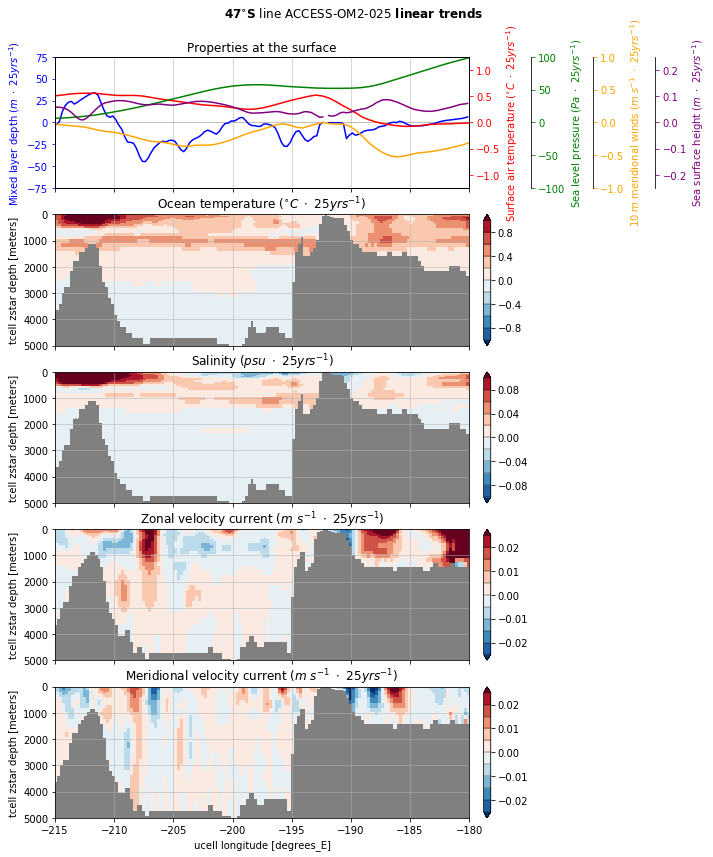

In [38]:
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(
        fig_dir, fig_name[0:4]+ekey+'_'+str(abs(lat_line))+'S_linear_trends.png'),
                dpi=300, bbox_inches="tight")  
    # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return    

# General plotting stuff
plot_labels=['(a) ','(b) ','(c) ','(d)']
land_50m= cft.NaturalEarthFeature('physical', 'land', '110m',
                                    edgecolor='black',
                                    facecolor='',
                                    linewidth=1)
fig = plt.figure() 
fig.set_size_inches(10,14)
matplotlib.rcParams.update({'font.size': 10}) 
col = 1
row = 5

fig.suptitle(r'$\bf{'+str(abs(lat_line))+'^{\circ}S}$ line ACCESS-OM2-025 $\\bf{linear\ trends}$', 
             x=0.54, y=0.93)

ax = plt.subplot2grid((row, col), (0, 0), rowspan=1, colspan=1)    
# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx(), ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.7)

# And finally we get to plot things...
ax_num = 0
color = 'Blue'
ax_now = axes[ax_num]
# ylim = 0.00002
ylim = 75
mld_plot = mld_slopes*25
ax_now.plot([lonW_lim+360, lonE+360],[0,0],linewidth=0.5,color='Gray')
ax_now.plot(mld_plot.x+360, mld_plot, color=color)
# ax_now.set_ylabel('Rain fall rate ($Kg\ m^{-2}\ s^{-1}$)', color=color)
ax_now.set_ylabel('Mixed layer depth ($m\ \cdot\ 25yrs^{-1}$)', color=color)
ax_now.tick_params(axis='y', colors=color)
plt.gca().set_xlim([lonW_lim+360, lonE+360])
ax_now.set_ylim([-ylim, ylim])

ax_num = 1
color = 'Red'
ax_now = axes[ax_num]
ylim = 1.25
t_10_plot = t_10_slopes*25
ax_now.plot(t_10_plot.x, t_10_plot, color=color)
ax_now.set_ylabel('Surface air temperature ($^{\circ}C\ \cdot\ 25yrs^{-1}$)', color=color)
ax_now.tick_params(axis='y', colors=color)
plt.gca().set_xlim([lonW_lim+360, lonE+360])
ax_now.set_ylim([-ylim, ylim])

ax_num = 2
color = 'Green'
axes[ax_num].spines['right'].set_position(('axes', 1.15))
ax_now = axes[ax_num]
ylim = 100
slp_plot = slp_slopes*25
ax_now.plot(t_10_plot.x, slp_plot, color=color)
ax_now.set_ylabel('Sea level pressure ($Pa\ \cdot\ 25yrs^{-1}$)', color=color)
ax_now.tick_params(axis='y', colors=color)
plt.gca().set_xlim([lonW_lim+360, lonE+360])
ax_now.set_ylim([-ylim, ylim])

ax_num = 3
color = 'Orange'
axes[ax_num].spines['right'].set_position(('axes', 1.3))
ax_now = axes[ax_num]
ylim = 1
v_10_plot = v_10_slopes*25
ax_now.plot(t_10_plot.x, v_10_plot, color=color)
ax_now.set_ylabel('10 $m$ meridional winds ($m\ s^{-1}\ \cdot\ 25yrs^{-1}$)', color=color)
ax_now.tick_params(axis='y', colors=color)
plt.gca().set_xlim([lonW_lim+360, lonE+360])
ax_now.set_ylim([-ylim, ylim])

ax_num = 4
color = 'Purple'
axes[ax_num].spines['right'].set_position(('axes', 1.45))
axes[ax_num].set_frame_on(True)
axes[ax_num].patch.set_visible(False)
ax_now = axes[ax_num]
ylim = 0.25
eta_t_plot = eta_t_slopes*25
ax_now.plot(eta_t_plot.x+360, eta_t_plot, color=color)
ax_now.set_ylabel('Sea surface height ($m\ \cdot\ 25yrs^{-1}$)', color=color)
ax_now.tick_params(axis='y', colors=color)
plt.gca().set_xlim([lonW_lim+360, lonE+360])
ax_now.set_ylim([-ylim, ylim])

axes[0].xaxis.grid(linewidth=0.5, linestyle='-')
axes[0].set_xlim([lonW_lim+360, lonE+360])
ax_now.set_xticklabels('')
ax_now.set_xlabel('')
ax_now.set_title('Properties at the surface')


ax = plt.subplot2grid((row, col), (1, 0), rowspan=1, colspan=1)
cmap = plt.get_cmap('RdBu_r')
levels = arange(-1,1,0.2)
temp_plot = temp_slopes*25
p = temp_plot.plot(add_colorbar=False, cmap=cmap, levels=levels, extend='both')
plt.title('Ocean temperature ($^{\circ}C\ \cdot\ 25yrs^{-1}$)')
ax.grid(linewidth=0.5, linestyle='-')
ax.set_xticks(arange(lonW_lim, lonE,5))
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_xlim([lonW_lim, lonE])
ax.set_ylim([0, 5000])
ax.set_facecolor('gray')
ax.invert_yaxis()

ax_pos = array(ax.get_position())
ax3 = plt.axes([ax_pos[1][0]+0.02, ax_pos[0][1], 0.01, ax_pos[1][1]-ax_pos[0][1]])
cbar = plt.colorbar(p, cax=ax3, orientation='vertical', drawedges=True)

ax = plt.subplot2grid((row, col), (2, 0), rowspan=1, colspan=1)
cmap = plt.get_cmap('RdBu_r')
levels = arange(-0.1,0.1,0.02)
salt_plot = salt_slopes*25
p = salt_plot.plot(add_colorbar=False, cmap=cmap, levels=levels, extend='both')
plt.title('Salinity ($psu\ \cdot\ 25yrs^{-1}$)')
ax.grid(linewidth=0.5, linestyle='-')
ax.set_xticks(arange(lonW_lim, lonE,5))
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_xlim([lonW_lim, lonE])
ax.set_ylim([0, 5000])
ax.set_facecolor('gray')
ax.invert_yaxis()

ax_pos = array(ax.get_position())
ax3 = plt.axes([ax_pos[1][0]+0.02, ax_pos[0][1], 0.01, ax_pos[1][1]-ax_pos[0][1]])
cbar = plt.colorbar(p, cax=ax3, orientation='vertical', drawedges=True)

ax = plt.subplot2grid((row, col), (3, 0), rowspan=1, colspan=1)
cmap = plt.get_cmap('RdBu_r')
levels = arange(-0.025,0.025,0.005)
u_plot = u_slopes*25
p = u_plot.plot(add_colorbar=False, cmap=cmap, levels=levels, extend='both')
plt.title('Zonal velocity current ($m\ s^{-1}\ \cdot\ 25yrs^{-1}$)')
ax.grid(linewidth=0.5, linestyle='-')
ax.set_xticks(arange(lonW_lim, lonE,5))
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_xlim([lonW_lim, lonE])
ax.set_ylim([0, 5000])
ax.set_facecolor('gray')
ax.invert_yaxis()

ax_pos = array(ax.get_position())
ax3 = plt.axes([ax_pos[1][0]+0.02, ax_pos[0][1], 0.01, ax_pos[1][1]-ax_pos[0][1]])
cbar = plt.colorbar(p, cax=ax3, orientation='vertical', drawedges=True)

ax = plt.subplot2grid((row, col), (4, 0), rowspan=1, colspan=1)
cmap = plt.get_cmap('RdBu_r')
levels = arange(-0.025,0.025,0.005)
v_plot = v_slopes*25
p = v_plot.plot(add_colorbar=False, cmap=cmap, levels=levels, extend='both')
plt.title('Meridional velocity current ($m\ s^{-1}\ \cdot\ 25yrs^{-1}$)')
ax.grid(linewidth=0.5, linestyle='-')
ax.set_xticks(arange(lonW_lim, lonE,5))
# ax.set_xticklabels('')
# ax.set_xlabel('')
ax.set_xlim([lonW_lim, lonE])
ax.set_ylim([0, 5000])
ax.set_facecolor('gray')
ax.invert_yaxis()

ax_pos = array(ax.get_position())
ax3 = plt.axes([ax_pos[1][0]+0.02, ax_pos[0][1], 0.01, ax_pos[1][1]-ax_pos[0][1]])
cbar = plt.colorbar(p, cax=ax3, orientation='vertical', drawedges=True)

savefigure(y)